In [1]:
import cdms
import rawio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

In [2]:
def low_pass_filter(data, alpha):
    """
    Applies a simple low-pass filter to a data series.

    :param data: a list or array of numeric data
    :param alpha: a smoothing factor between 0 and 1
    :return: a list containing the filtered data
    """
    filtered = [data[0]]  # initialize the filtered data with the first value of the input
    for i in range(1, len(data)):
        filtered.append(alpha * data[i] + (1 - alpha) * filtered[-1])
    return filtered



def butter_lowpass_filter(data, cutoff_frequency, sampling_rate=625000, order=4):
    cutoff_frequency *= 1000
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

In [5]:
#chanNames=["PAS1","PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"]
chanNames=["PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"]
chanNames=["PBS1"]


# SLAC
#09220804_090551
#09220804_080938
filepath = "/sdf/home/y/yanliu/09220804_080938_F0001.mid.gz"

# CUTE
#23231113_151724
#filepath = ""


myreader = rawio.RawDataReader(filepath)

events = myreader.read_events(output_format=2,
                                  nb_events=50,
                                  skip_empty=True,
                                  #event_nums=[50019,50306],
                                  #event_nums=[60094,60623],
                                  #event_nums=[120177,120707],
                                  trigger_types=[2],
                                  detector_nums=[3],
                                  channel_names=chanNames)

INFO: Found 1 midas raw data files
The file is: /sdf/home/y/yanliu/09220804_080938_F0001.mid.gz

Opened raw midas file: /sdf/home/y/yanliu/09220804_080938_F0001.mid.gz


In [6]:
events[0]["event"]["EventNumber"]

10001

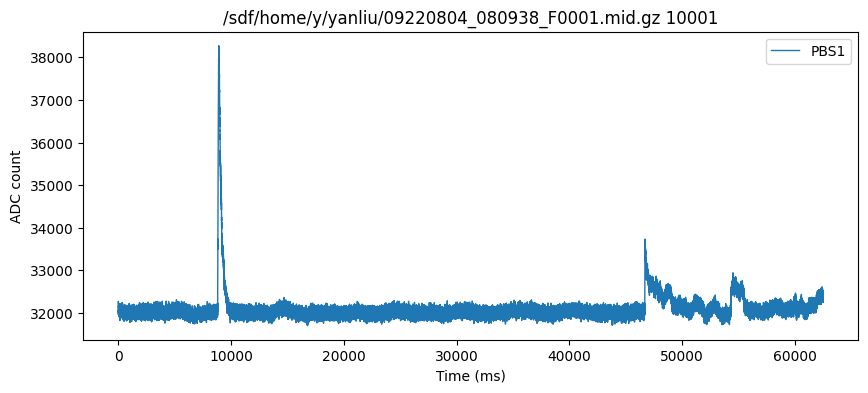

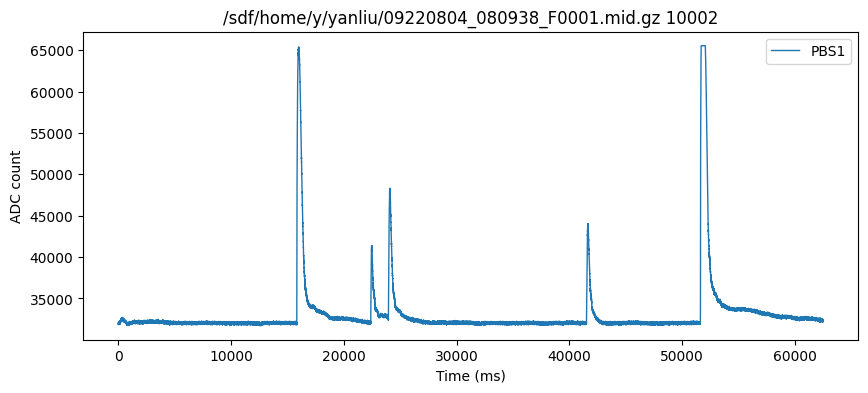

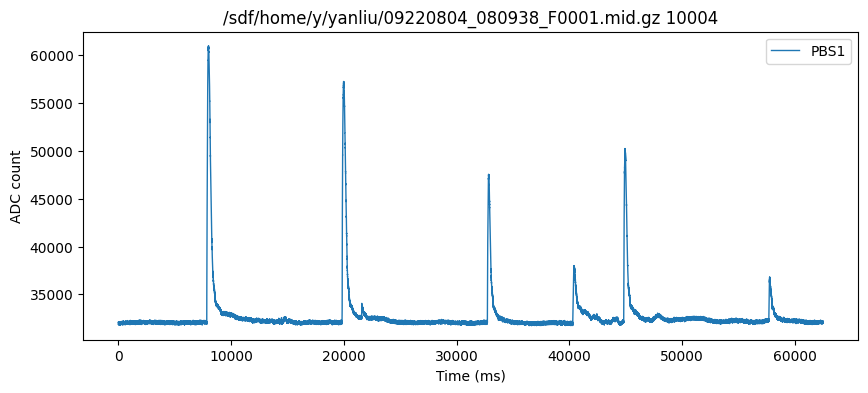

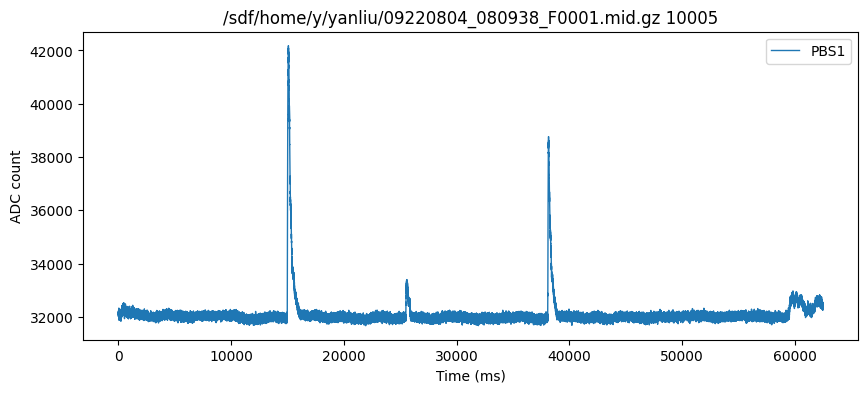

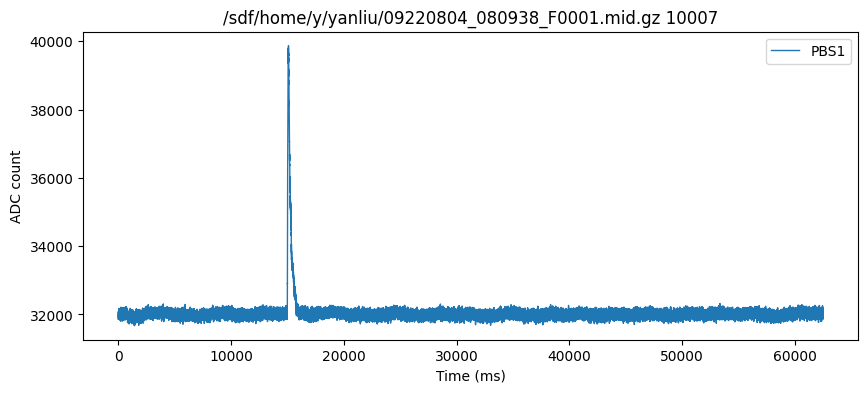

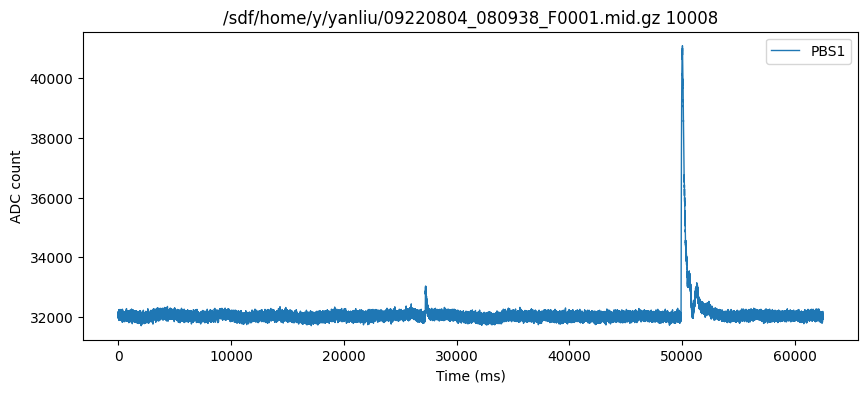

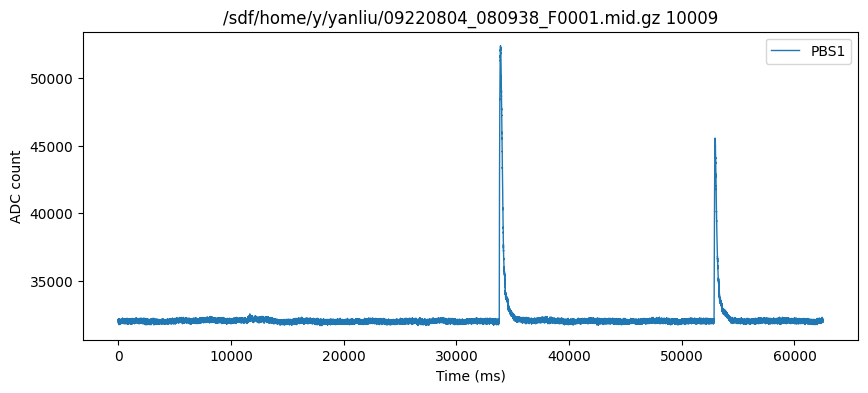

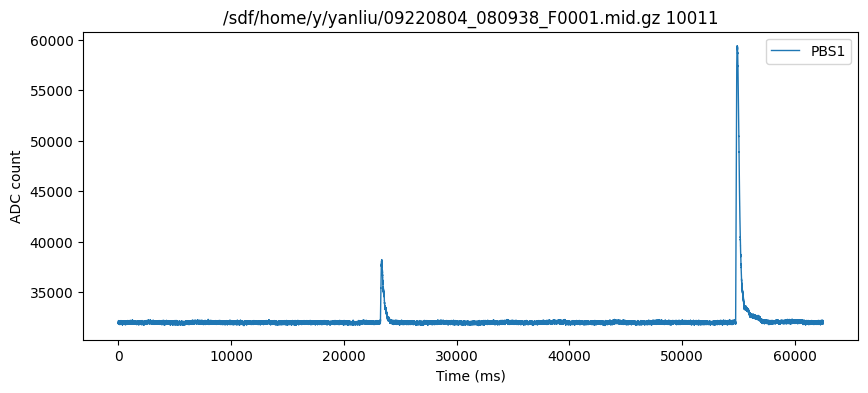

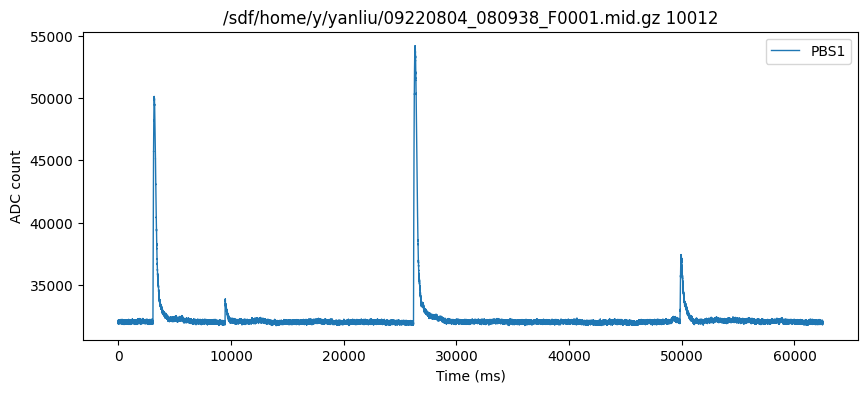

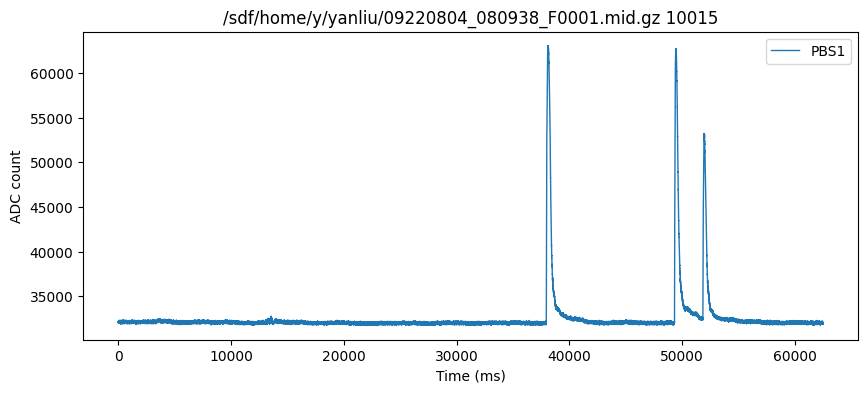

In [9]:
pt_events = []

sampling_interval = 1/625
low_bound = 15800
up_bound = 17000

for id in range(0,10):
    traces = events[id]["Z3"]

    plt.figure(figsize=(10, 4))
    #if (id==0):
        #plt.title("1.3keV Ge activation events from a SuperCDMS Ge HV detector operated at 50V")
    pt = np.zeros(62512)
    ctr = 0    
    for chan in chanNames:
        pt += traces[chan]
        ctr += 1
        #plt.plot(low_pass_filter(traces[chan], 1)[15800:16700], label=chan, linewidth=3)
        time = np.arange(0, len(traces[chan]) * sampling_interval, sampling_interval)
        #plt.plot(time[low_bound:up_bound], butter_lowpass_filter(traces[chan], 50)[low_bound:up_bound], label=chan, linewidth=1)
        #plt.plot(time, traces[chan], label=chan, linewidth=1)
        plt.plot(traces[chan], label=chan, linewidth=1)

        plt.title(filepath+" "+str(events[id]["event"]["EventNumber"]))
        plt.xlabel("Time (ms)")
        plt.ylabel("ADC count")
    pt /= ctr
    pt_events.append(pt)
    plt.legend()

#plt.draw()
#plt.savefig('output_plot.pdf')


    

In [10]:
evtNums = [10001, 10007, 10015, 10016, 10020, 10022, 10028]
trace_ranges = [[12000,42000],[20000,50000],[2000,32000],[10000,40000], [10000,40000],[30000,60000],[10000,40000]]

In [11]:
events_selected = myreader.read_events(output_format=2,
                                  skip_empty=True,
                                  event_nums=evtNums,
                                  trigger_types=[2],
                                  detector_nums=[3],
                                  channel_names=chanNames)

The file is: /sdf/home/y/yanliu/09220804_080938_F0001.mid.gz

Opened raw midas file: /sdf/home/y/yanliu/09220804_080938_F0001.mid.gz


In [18]:
trace_ranges[0]

[12000, 42000]

[32099 31857 32025 ... 31908 31969 31910]
[31998 32102 32015 ... 32022 32039 32016]
[32150 32246 32099 ... 32002 32189 32012]
[32249 32371 32358 ... 32186 32276 32241]
[31967 32144 31945 ... 32003 31824 32049]
[32196 32348 32295 ... 32069 31954 32100]
[32131 31944 32074 ... 32018 32015 32101]


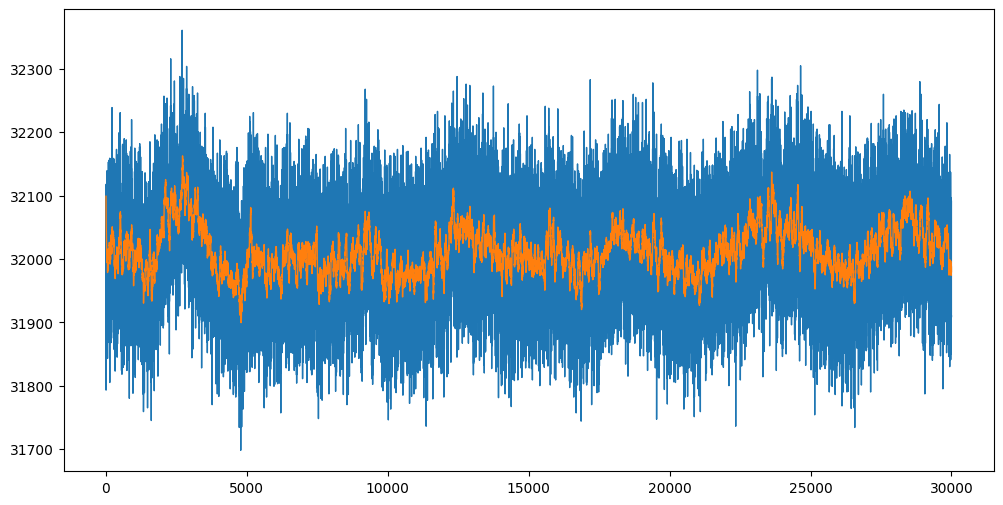

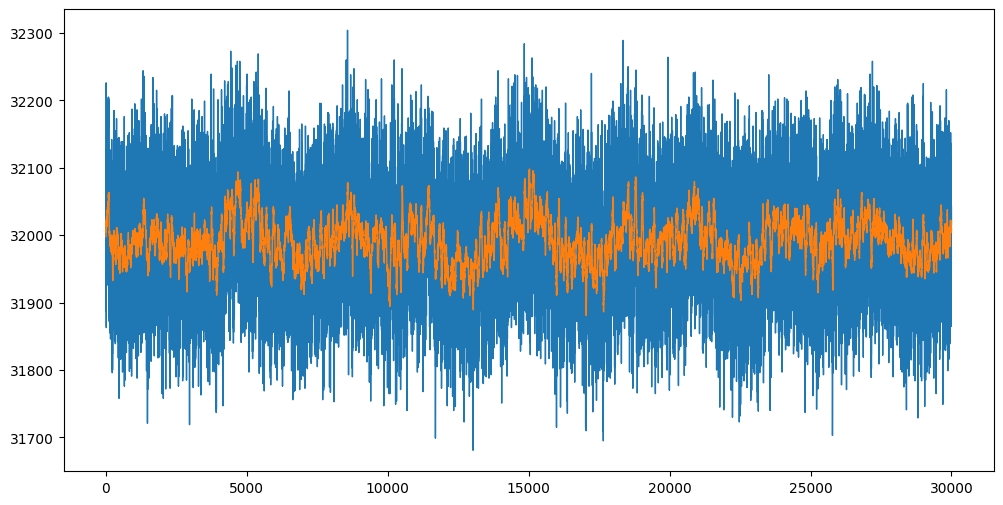

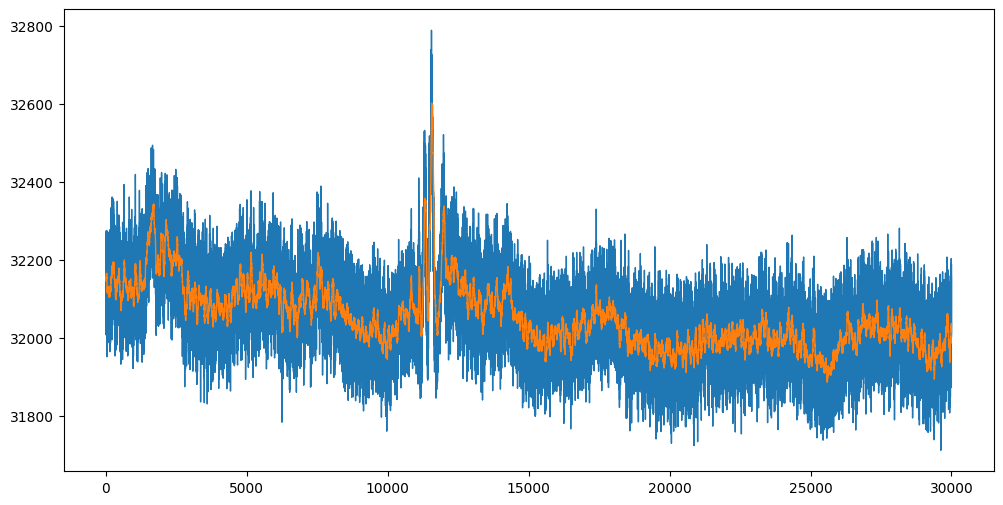

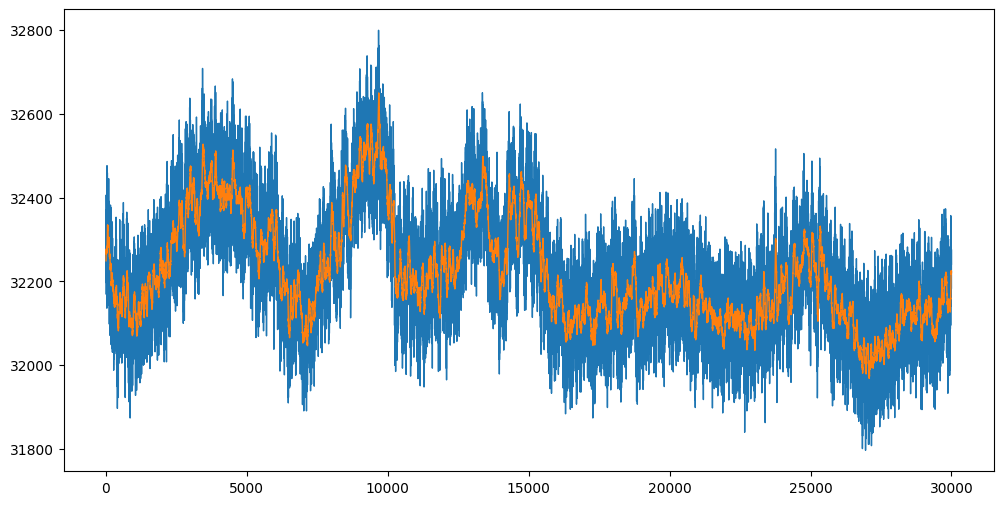

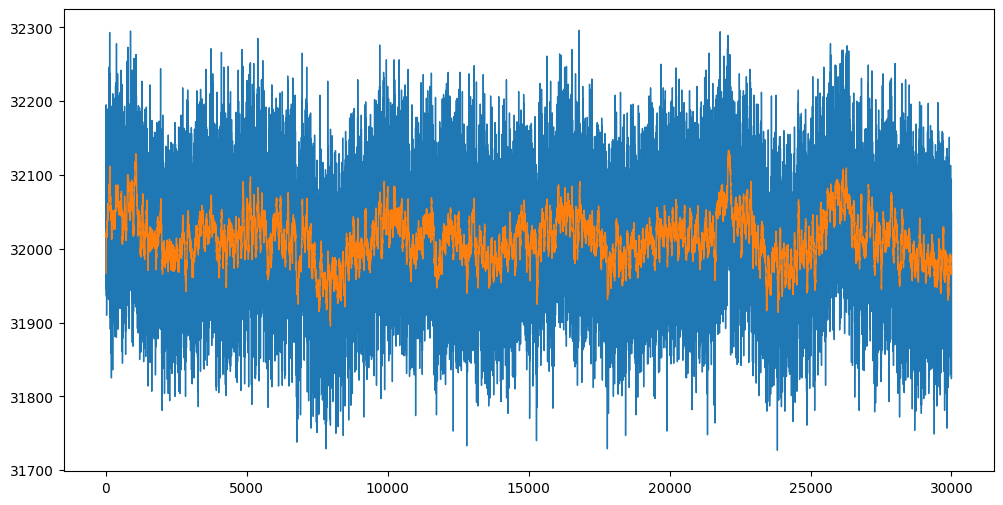

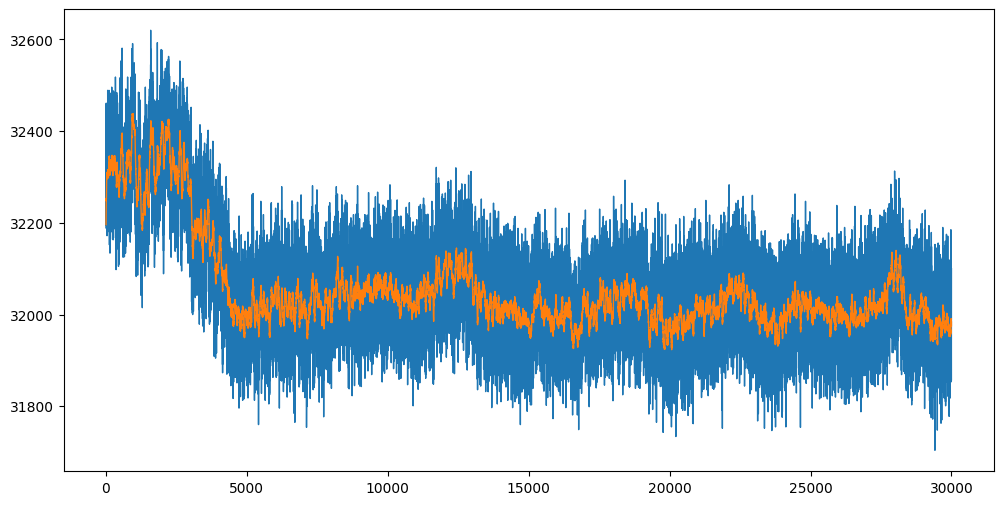

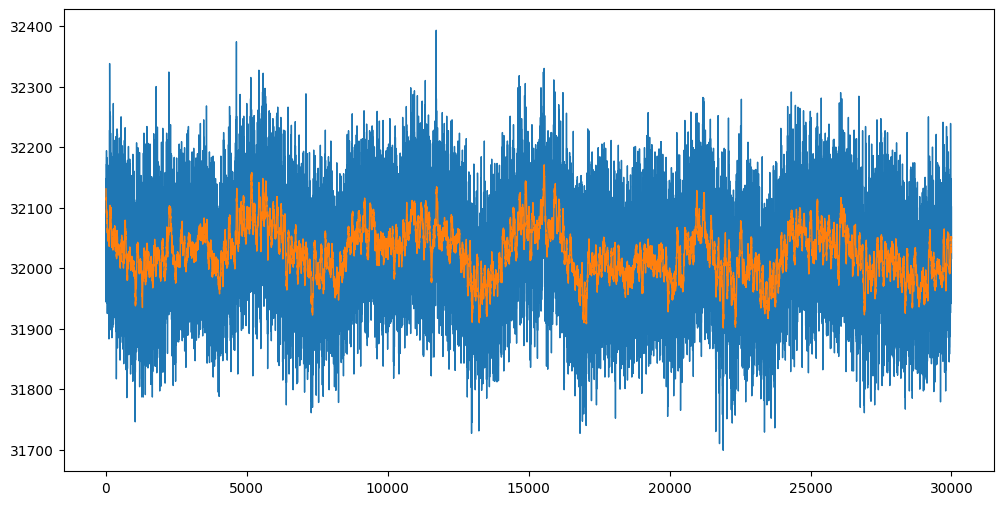

In [40]:
sampling_interval = 1/625000

def calculate_psd(signal, fs):
    # Compute FFT
    fft_result = np.fft.fft(signal)
    
    # Calculate one-sided PSD
    psd = (1 / (fs * len(signal))) * np.abs(fft_result)**2
    psd = 2 * psd[:len(signal)//2]  # Multiply by 2 to account for one-sided spectrum
    
    # Frequency axis
    freq = np.fft.fftfreq(len(signal), 1/fs)
    
    return freq[:len(signal)//2], psd


sample_freq = 625000


for id in range(7):
    traces = events_selected[id]["Z3"]

    plt.figure(figsize=(12, 6))
    for chan in chanNames:
        time = np.arange(0, len(traces[chan]) * sampling_interval, sampling_interval)
        #plt.plot(time, traces[chan], label=chan, linewidth=1)
        upper_bound = trace_ranges[id][0]
        lower_bound = trace_ranges[id][1]
        trace = traces[chan][upper_bound:lower_bound]
        print (trace)
        plt.plot(low_pass_filter(trace,1), label="original trace", linewidth=1)
        plt.plot(low_pass_filter(trace,0.05), label="low pass filtered", linewidth=1)
        #plt.title(filepath+" "+str(events_selected[id]["event"]["EventNumber"]))
        #plt.xlabel("Time (s)")
        #plt.ylabel("ADC count")
        freq, psd = calculate_psd(trace, sample_freq)
        #print(freq, psd)
        #plt.plot(psd, label=chan, linewidth=1)
        #plt.xscale("log")
        #plt.yscale("log")
        #plt.ylim(1e-8,100)





[32099 31857 32025 ... 31908 31969 31910]
[0.00000000e+00 2.08333333e+01 4.16666667e+01 ... 3.12437500e+05
 3.12458333e+05 3.12479167e+05] [9.83746505e+07 4.67588431e+00 1.75021155e+00 ... 1.17408212e-05
 3.13007120e-04 1.26533030e-04]
[31998 32102 32015 ... 32022 32039 32016]
[0.00000000e+00 2.08333333e+01 4.16666667e+01 ... 3.12437500e+05
 3.12458333e+05 3.12479167e+05] [9.82525755e+07 1.00583057e-01 9.06789474e-02 ... 1.38544517e-04
 9.52364801e-05 2.44946660e-04]
[32150 32246 32099 ... 32002 32189 32012]
[0.00000000e+00 2.08333333e+01 4.16666667e+01 ... 3.12437500e+05
 3.12458333e+05 3.12479167e+05] [9.86328282e+07 1.13045765e+02 1.54590263e+01 ... 3.26264330e-04
 1.36195770e-04 1.57440784e-04]
[32249 32371 32358 ... 32186 32276 32241]
[0.00000000e+00 2.08333333e+01 4.16666667e+01 ... 3.12437500e+05
 3.12458333e+05 3.12479167e+05] [9.96610817e+07 2.67460932e+02 5.52996682e+00 ... 3.53257356e-05
 9.09452903e-06 2.09672715e-04]
[31967 32144 31945 ... 32003 31824 32049]
[0.00000000e+0

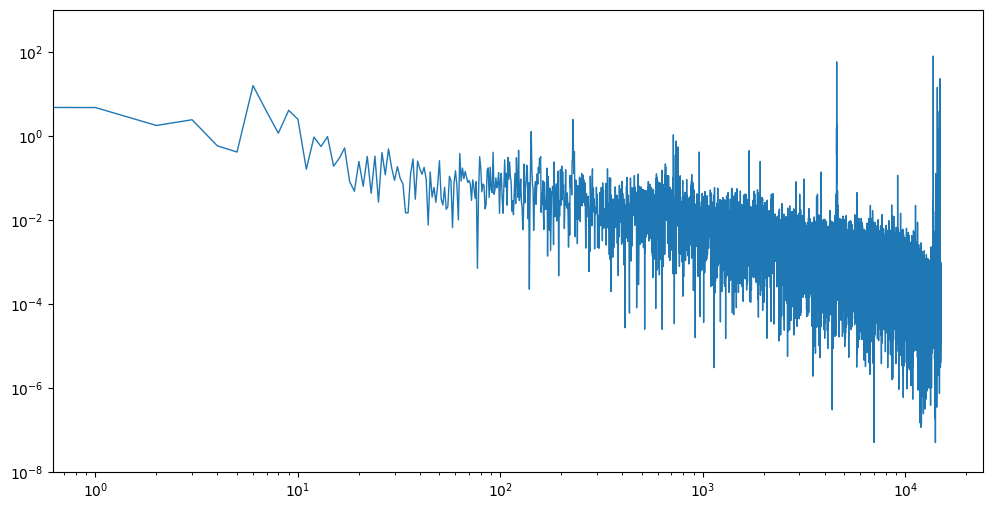

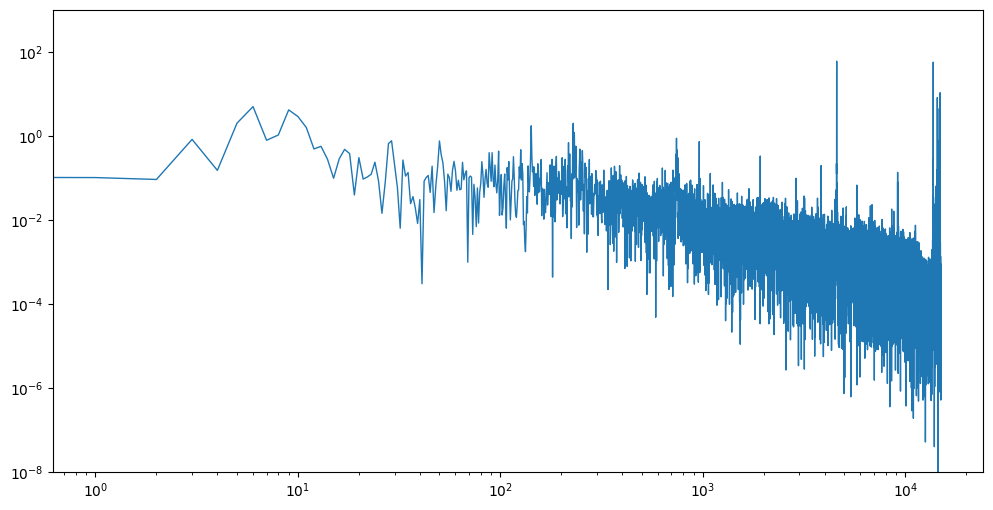

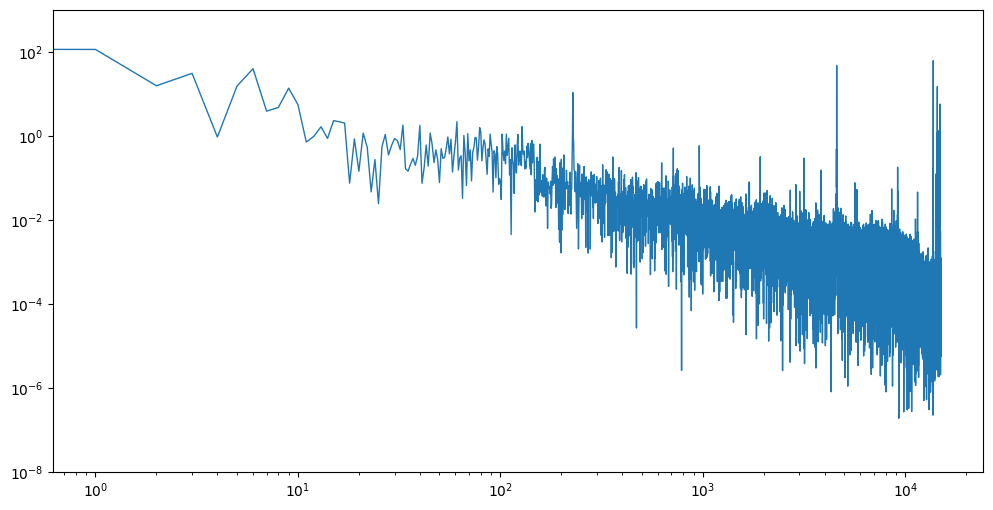

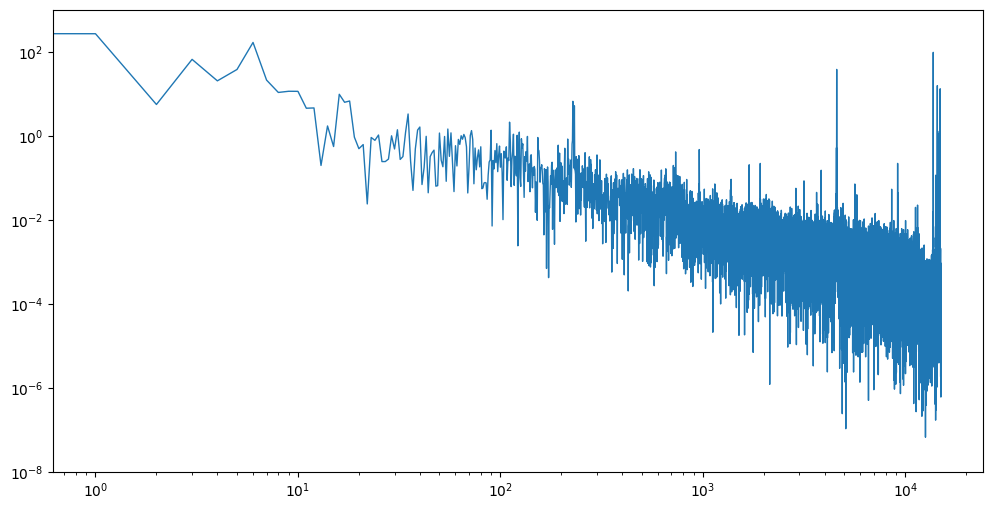

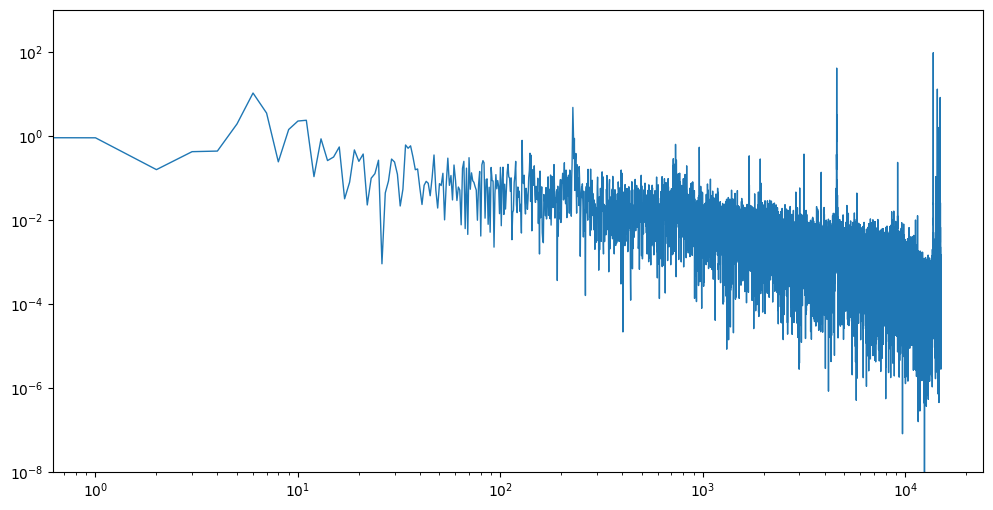

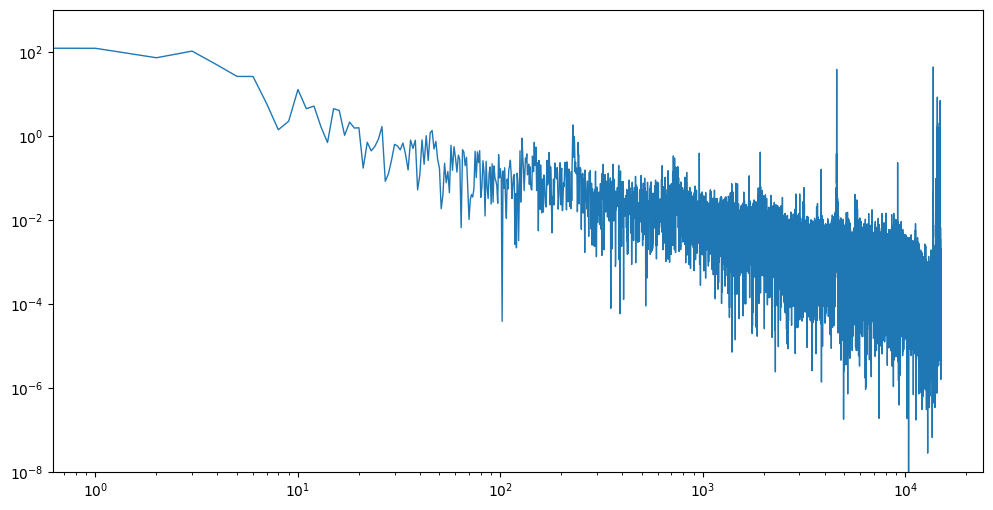

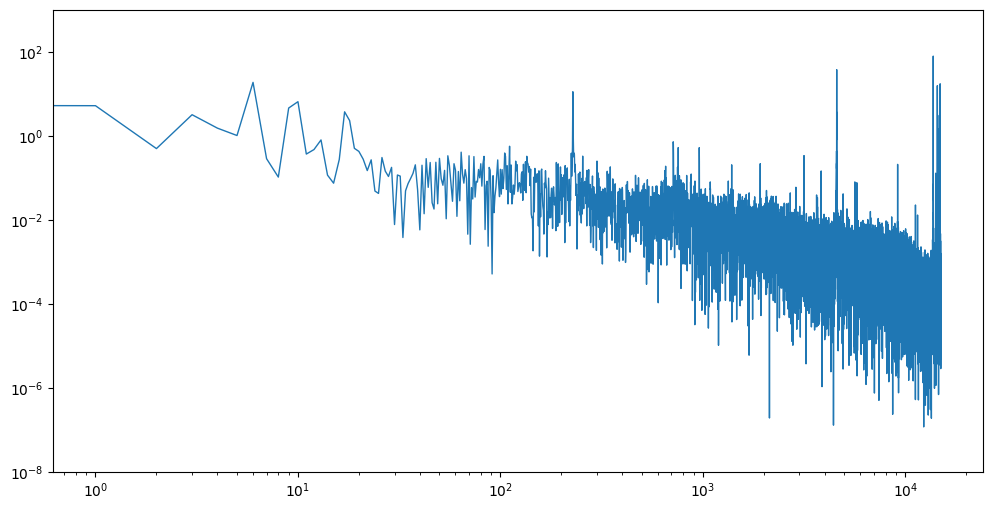

In [52]:
psd_SLAC = []


for id in range(7):
    traces = events_selected[id]["Z3"]

    plt.figure(figsize=(12, 6))
    for chan in chanNames:
        time = np.arange(0, len(traces[chan]) * sampling_interval, sampling_interval)
        #plt.plot(time, traces[chan], label=chan, linewidth=1)
        upper_bound = trace_ranges[id][0]
        lower_bound = trace_ranges[id][1]
        trace = traces[chan][upper_bound:lower_bound]
        print (trace)
        #plt.plot(low_pass_filter(trace,1), label="original trace", linewidth=1)
        #plt.plot(low_pass_filter(trace,0.05), label="low pass filtered", linewidth=1)
        #plt.title(filepath+" "+str(events_selected[id]["event"]["EventNumber"]))
        #plt.xlabel("Time (s)")
        #plt.ylabel("ADC count")
        freq, psd = calculate_psd(trace, sample_freq)
        print(freq, psd)
        plt.plot(psd, label=chan, linewidth=1)
        plt.xscale("log")
        plt.yscale("log")
        plt.ylim(1e-8,1000)
        psd_SLAC.append(psd)

In [43]:
#chanNames=["PAS1","PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"]
chanNames=["PBS1","PCS1","PDS1","PES1","PFS1","PAS2","PBS2","PCS2","PDS2","PES2","PFS2"]
chanNames=["PBS1"]


# SLAC
#09220804_090551
#09220804_080938
filepath = "/sdf/home/y/yanliu/09220804_080938_F0001.mid.gz"

# CUTE
#23231113_151724
filepath = "/fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R36/Raw/23231113_151724/23231113_151724_F0001.mid.gz"


myreader = rawio.RawDataReader(filepath)

events = myreader.read_events(output_format=2,
                                  nb_events=50,
                                  skip_empty=True,
                                  #event_nums=[50019,50306],
                                  #event_nums=[60094,60623],
                                  #event_nums=[120177,120707],
                                  trigger_types=[2],
                                  detector_nums=[3],
                                  channel_names=chanNames)

INFO: Found 1 midas raw data files
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R36/Raw/23231113_151724/23231113_151724_F0001.mid.gz

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R36/Raw/23231113_151724/23231113_151724_F0001.mid.gz


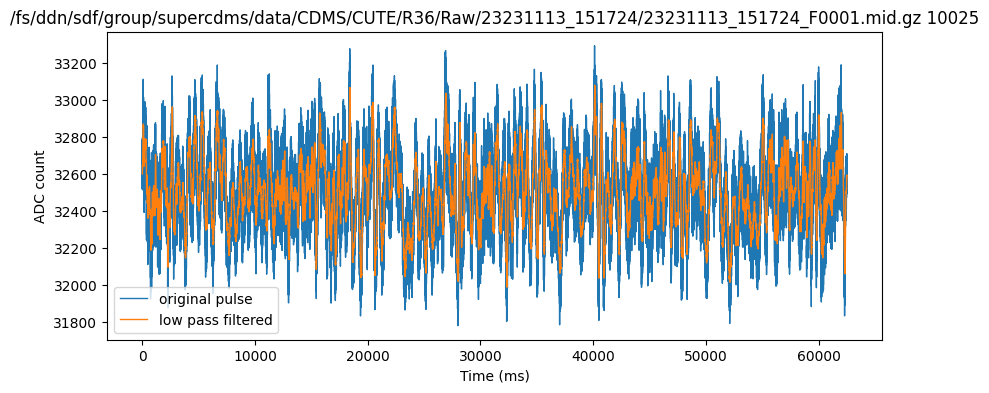

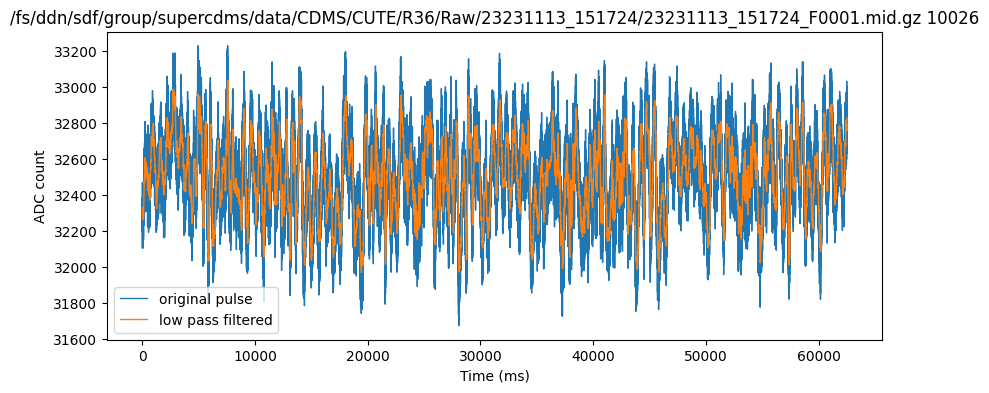

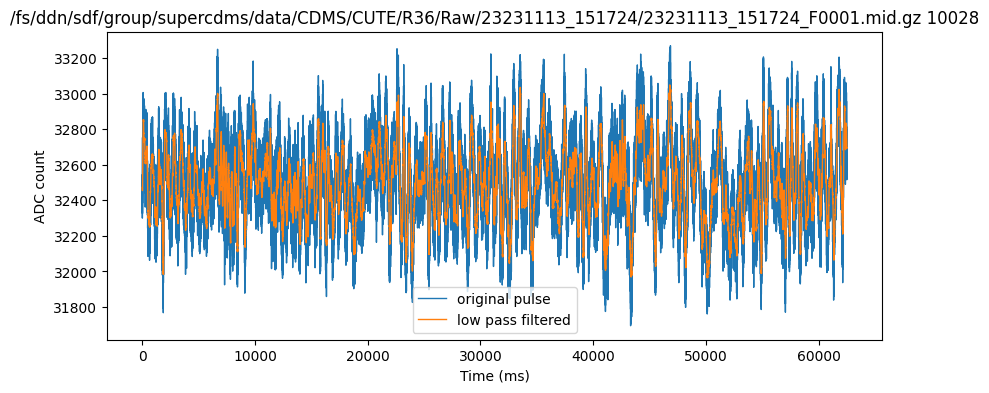

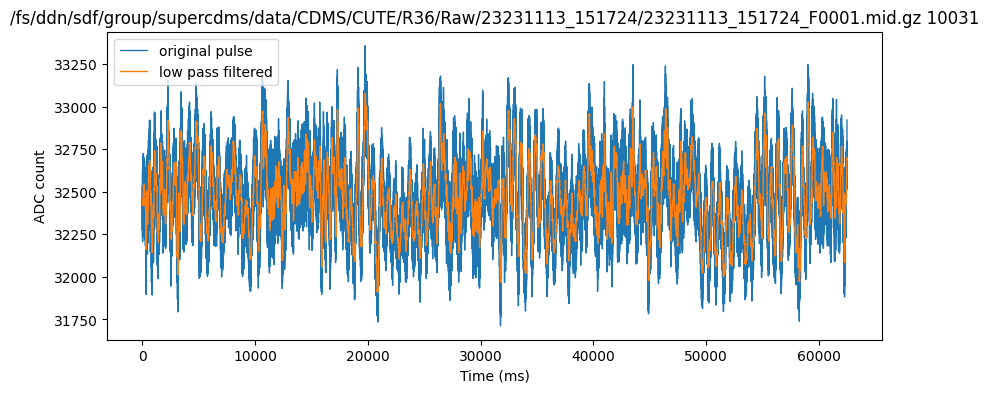

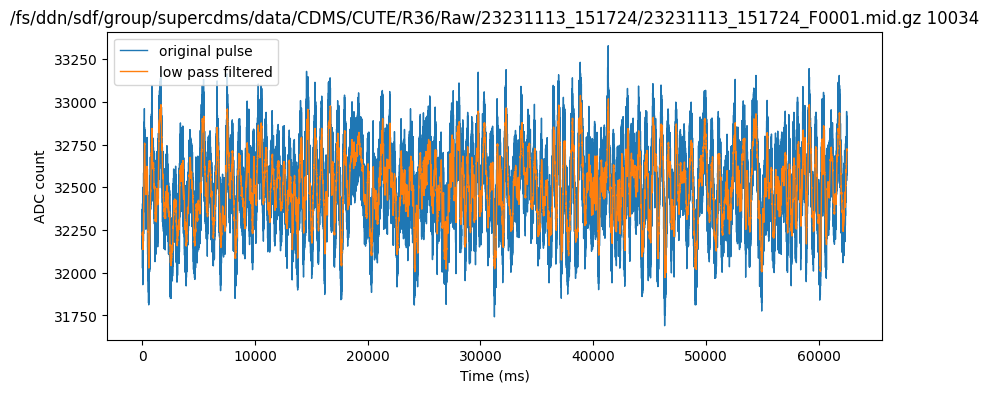

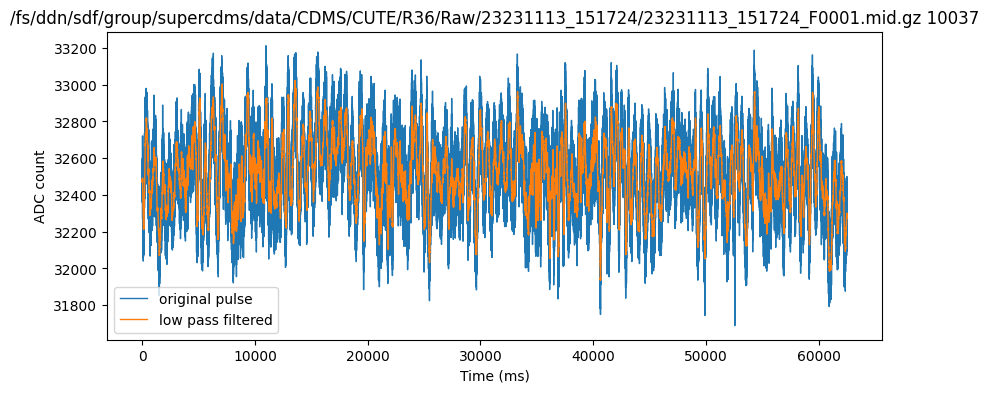

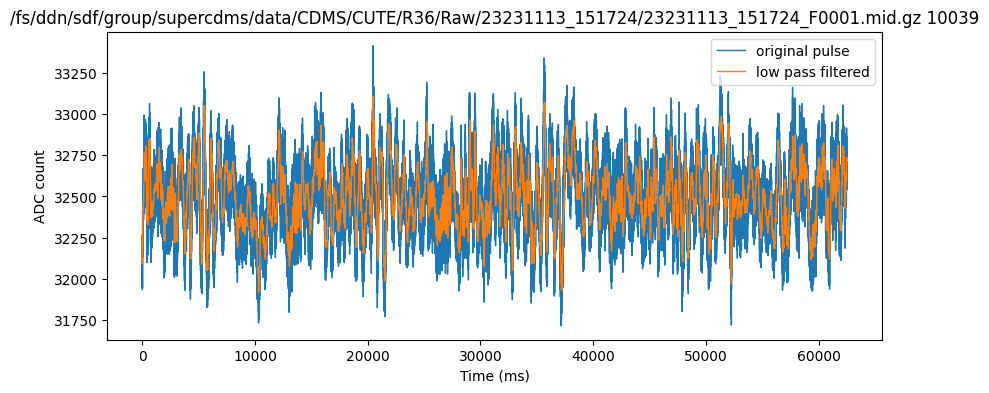

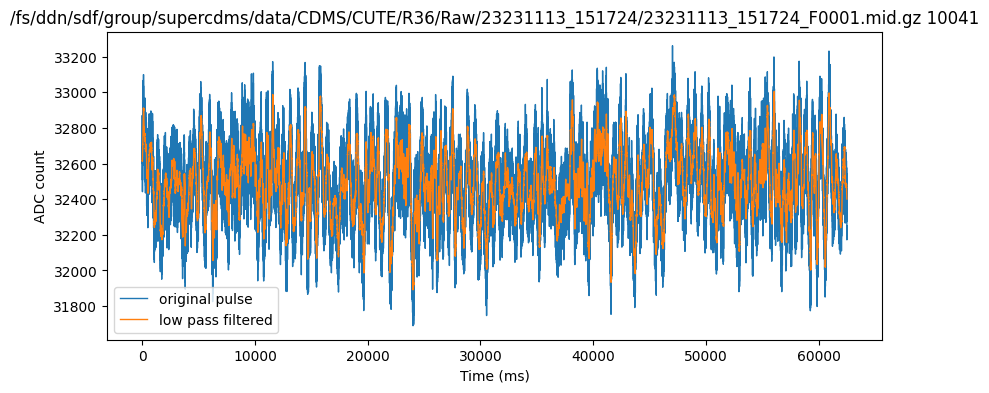

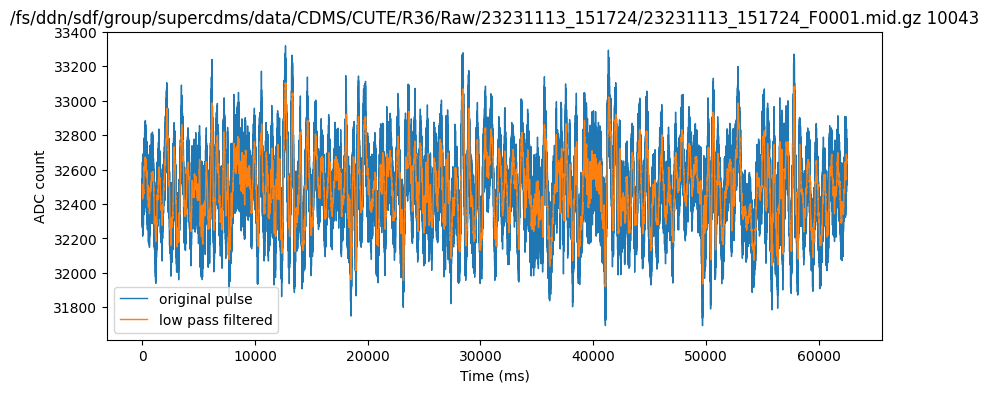

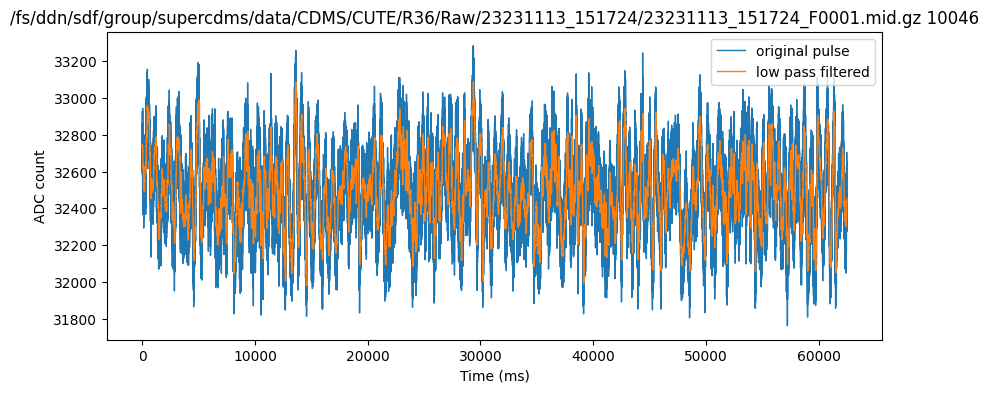

In [49]:
for id in range(10,20):
    traces = events[id]["Z3"]

    plt.figure(figsize=(10, 4))
    #if (id==0):
        #plt.title("1.3keV Ge activation events from a SuperCDMS Ge HV detector operated at 50V")
    pt = np.zeros(62512)
    ctr = 0    
    for chan in chanNames:
        pt += traces[chan]
        ctr += 1
        plt.plot(low_pass_filter(traces[chan], 1), label="original pulse", linewidth=1)
        #time = np.arange(0, len(traces[chan]) * sampling_interval, sampling_interval)
        #plt.plot(time[low_bound:up_bound], butter_lowpass_filter(traces[chan], 50)[low_bound:up_bound], label=chan, linewidth=1)
        #plt.plot(time, traces[chan], label=chan, linewidth=1)
        plt.plot(low_pass_filter(traces[chan],0.05), label="low pass filtered", linewidth=1)

        plt.title(filepath+" "+str(events[id]["event"]["EventNumber"]))
        plt.xlabel("Time (ms)")
        plt.ylabel("ADC count")
    pt /= ctr
    plt.legend()

[32569 32405 32481 ... 32607 32354 32676]
[0.00000000e+00 2.08333333e+01 4.16666667e+01 ... 3.12437500e+05
 3.12458333e+05 3.12479167e+05] [1.01149945e+08 8.93181363e+00 3.55108126e+01 ... 3.19503257e-04
 5.10057695e-04 2.20615414e-03]
[32661 32822 32662 ... 32341 32419 32321]
[0.00000000e+00 2.08333333e+01 4.16666667e+01 ... 3.12437500e+05
 3.12458333e+05 3.12479167e+05] [1.01321618e+08 1.00086306e+01 2.51953477e+01 ... 1.36574037e-03
 1.54637068e-03 3.31462008e-04]
[32561 32421 32542 ... 32388 32482 32418]
[0.00000000e+00 2.08333333e+01 4.16666667e+01 ... 3.12437500e+05
 3.12458333e+05 3.12479167e+05] [1.01431994e+08 1.07886830e+01 7.22651418e+00 ... 1.83479511e-04
 2.72678085e-04 3.11090620e-04]
[32291 32045 32123 ... 32983 32687 32900]
[0.00000000e+00 2.08333333e+01 4.16666667e+01 ... 3.12437500e+05
 3.12458333e+05 3.12479167e+05] [1.01217341e+08 4.69962430e+01 4.79982598e+00 ... 1.23610484e-03
 4.48574207e-04 1.24710628e-03]
[32812 32489 32821 ... 32484 32772 32478]
[0.00000000e+0

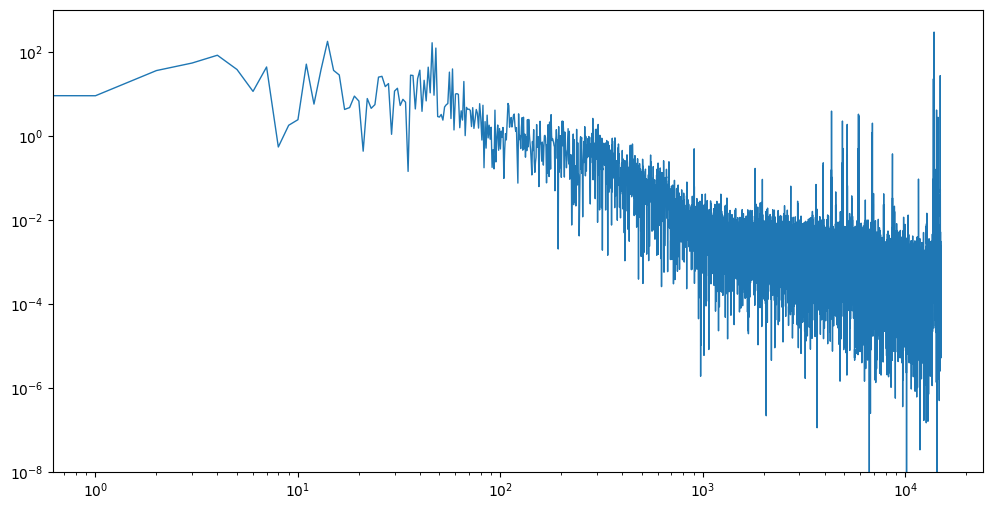

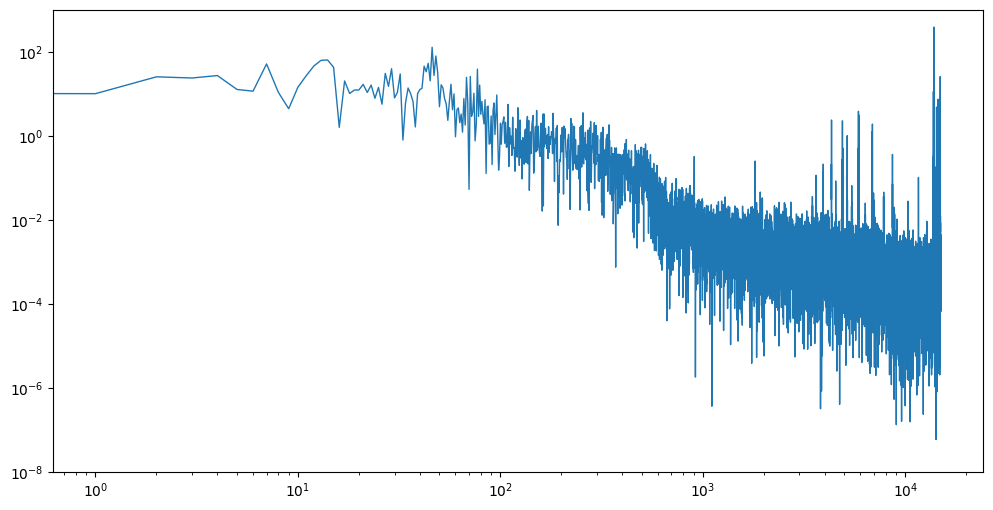

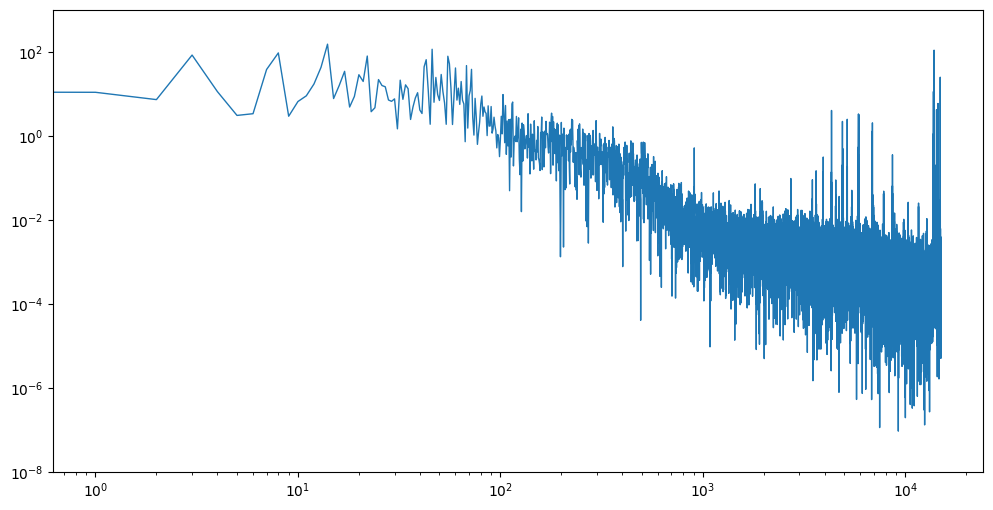

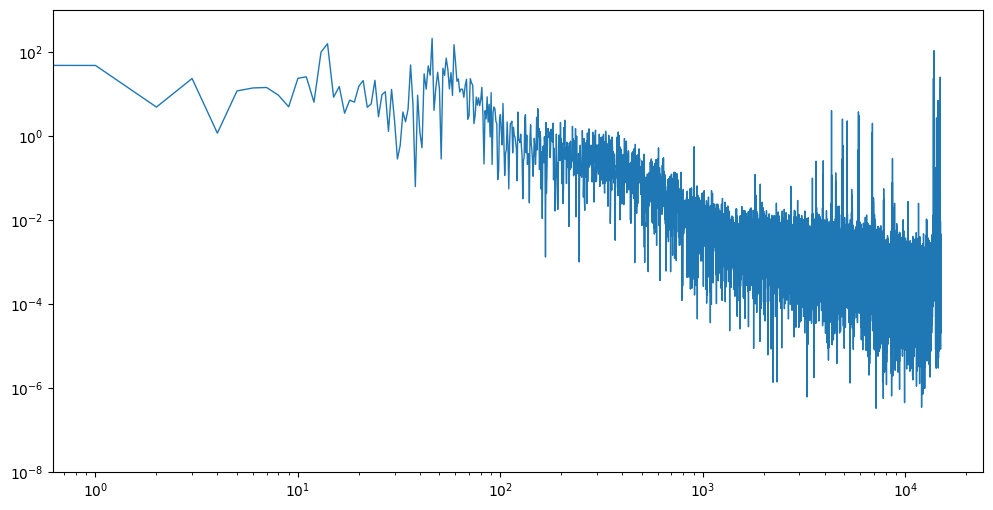

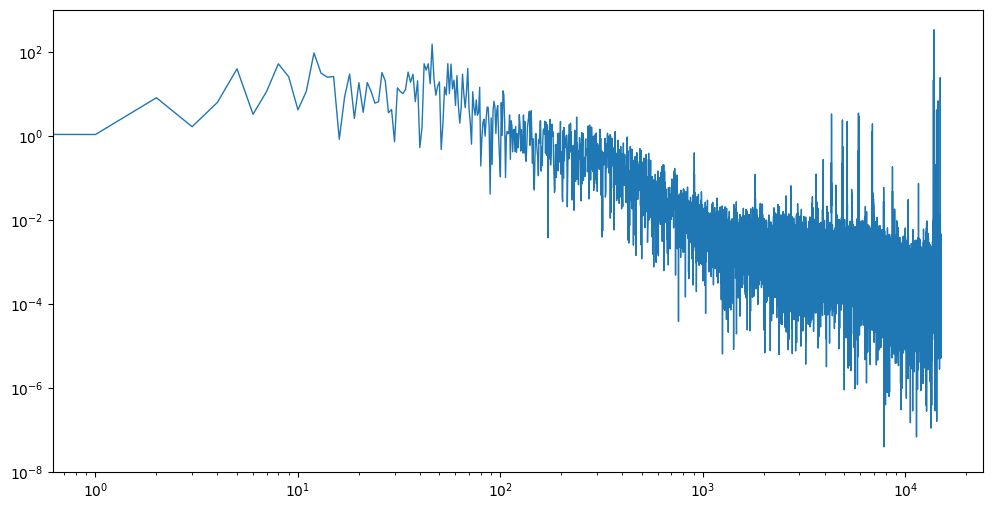

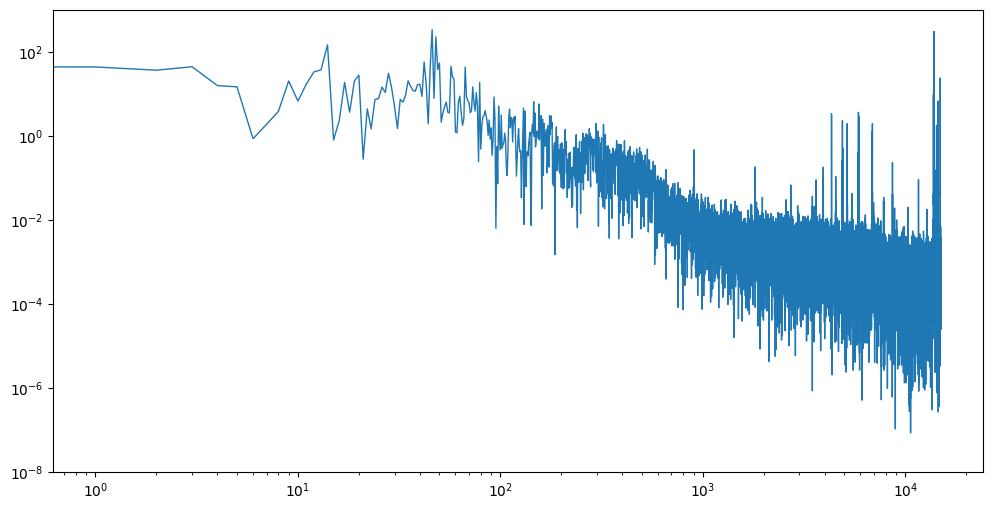

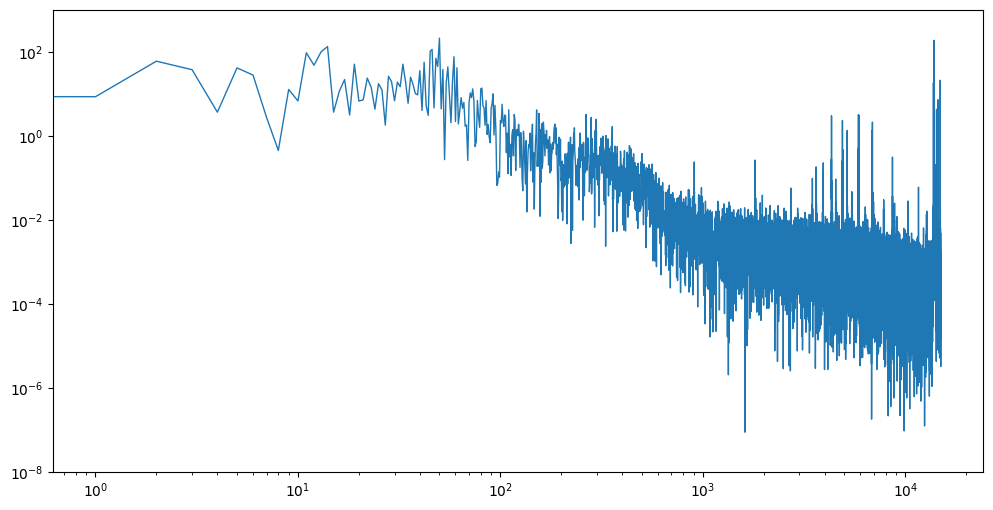

In [51]:
psd_CUTE = []
for id in range(7):
    traces = events[id]["Z3"]

    plt.figure(figsize=(12, 6))
    for chan in chanNames:
        time = np.arange(0, len(traces[chan]) * sampling_interval, sampling_interval)
        #plt.plot(time, traces[chan], label=chan, linewidth=1)
        upper_bound = trace_ranges[id][0]
        lower_bound = trace_ranges[id][1]
        trace = traces[chan][upper_bound:lower_bound]
        print (trace)
        #plt.plot(low_pass_filter(trace,1), label="original trace", linewidth=1)
        #plt.plot(low_pass_filter(trace,0.05), label="low pass filtered", linewidth=1)
        #plt.title(filepath+" "+str(events_selected[id]["event"]["EventNumber"]))
        #plt.xlabel("Time (s)")
        #plt.ylabel("ADC count")
        freq, psd = calculate_psd(trace, sample_freq)
        print(freq, psd)
        plt.plot(psd, label=chan, linewidth=1)
        plt.xscale("log")
        plt.yscale("log")
        plt.ylim(1e-8,1000)
        psd_CUTE.append(psd)